
참고: https://dacon.io/competitions/official/235736/codeshare/2835?page=1&dtype=recent

In [1]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action='ignore')

# font
plt.rc('font', family='gulim') # For Windows

In [2]:
# 데이터 로드
train = pd.read_csv('./data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   num          122400 non-null  int64  
 1   date_time    122400 non-null  object 
 2   전력사용량(kWh)   122400 non-null  float64
 3   기온           122400 non-null  float64
 4   풍속(m/s)      122400 non-null  float64
 5   습도(%)        122400 non-null  float64
 6   강수량(mm|6시간)  122400 non-null  float64
 7   일조(hr|)      122400 non-null  float64
 8   비전기냉방설비운영    122400 non-null  float64
 9   태양광보유        122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


결측치는 나오지 않음

컬럼을 영어로 변경함

In [4]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
train = pd.read_csv('./data/train.csv', encoding='utf8', names=train_col, header=0)
train.head(10)

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0


In [5]:
# date_time에 따른 feature 추가
train['date_time'] = pd.to_datetime(train['date_time'])
train['date'] = train['date_time'].dt.date
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].dt.weekday # 0: 월요일
train['weekend'] = train['weekday'].isin([5,6]).astype(int) # 주말
train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,date,day,month,hour,weekday,weekend,dayofyear
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,1,6,0,0,0,153
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,6,1,0,0,153
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,2,0,0,153
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,3,0,0,153
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,4,0,0,153


### 날씨 흐름과 전력사용량

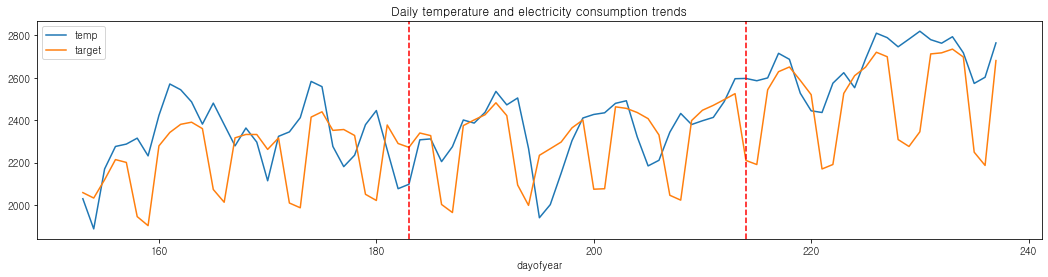

In [6]:
# 일별 기온 및 전력사용량 추이
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('Daily temperature and electricity consumption trends')
plt.show()

6월에서 8월로 갈 수록 전력사용량 증가하는것을 알 수 있고, 전력사용량은 보통 기온의 영향을 받는것 같으나 예외의 경우도 존재한다.

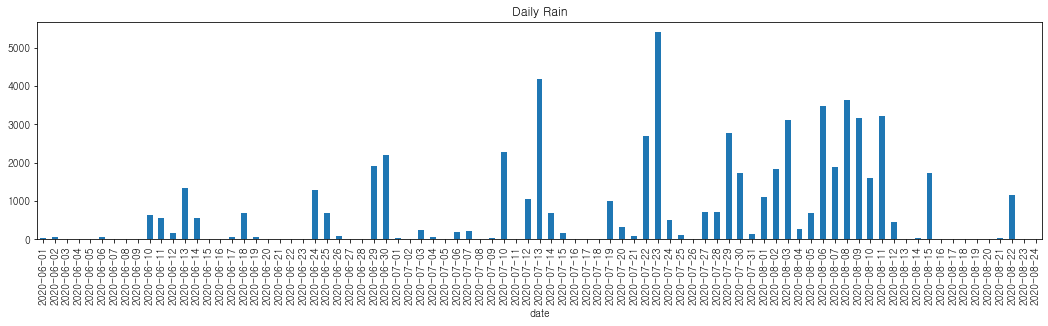

In [7]:
# 일별 강수량 추이
(train.groupby(['date'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('Daily Rain')
plt.show()

7~8월은 장마기간 
검색 결과 6월에서 시작해 8월 초에 끝나는 것을 알 수 있다.
https://news.mt.co.kr/mtview.php?no=2020082110461160385

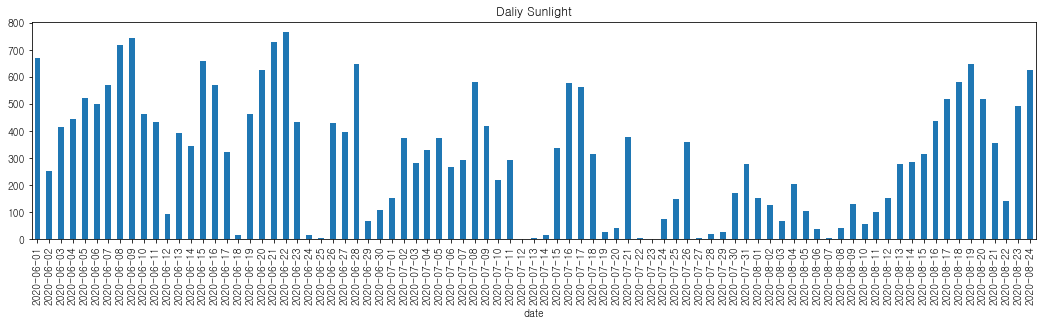

In [8]:
# 일별 일조량
train.groupby(['date'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('Daliy Sunlight')
plt.show()

### 건물별 전력 사용 패턴 분석

1 군집화를 통한 유형 분류

In [9]:
train_origin = train.copy()

In [10]:
# 정확한 군집화를 위한 스케일링
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean() # 평균
    std_ = train.loc[train.num == i].target.std()   # 표준편차
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [11]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [12]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [13]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [14]:
# 보기 편하게 컬럼 이름 지정
columns = (
    ['num']
    + ['mon','tue','wed','thu','fri','sat','sun'] 
    + [str(i)+'h' for i in range(24)]
)

cl_df.columns = columns

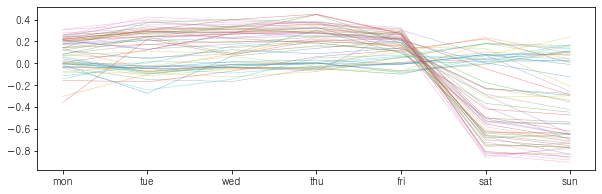

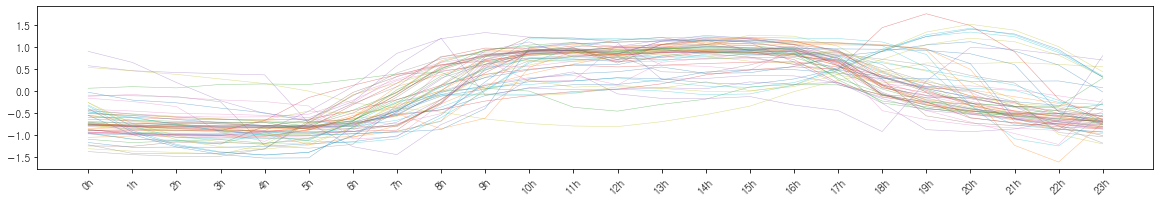

In [15]:
# 시각화를 통한 확인
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

2. 건물 군집 유형 비교 

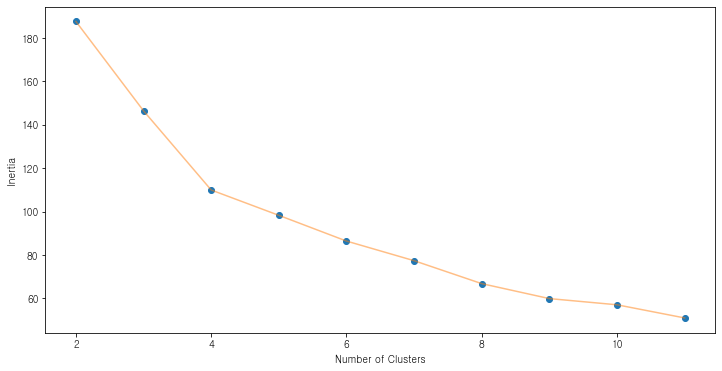

In [16]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

엘보우 포인트: 4
4개의 건물유형으로 나눠볼 수 있다.

In [17]:
# 엘보우 포인트를 통해 kmeans 클러스터링
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [18]:
# 값 할당
cl_df['km_cluster'] = pred

# 기존 train set과 merge
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [19]:
# 군집별 분석을 위한 4개의 데이터셋 할당
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [21]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040   # .to_frame() : 프레임으로 만들어 보여주는것, /2040: 정규화

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


건물 수(비율) : 1번 > 3번 > 0번 > 2번

유형별로 시간대별 전기사용량을 알아봅니다.

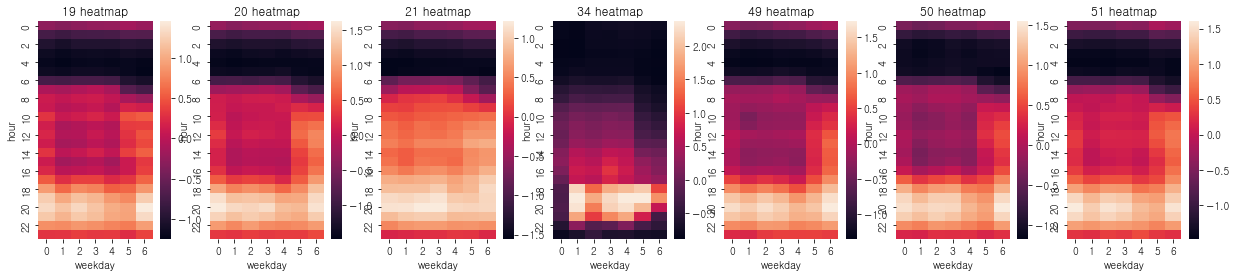

In [22]:
# km_0 번
fig = plt.figure(figsize=(21, np.ceil(len(km_0)/7)*4))
for i, n in enumerate(km_0):
    plt.subplot(int(np.ceil(len(km_0)/7)), 7, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

일주일 운영, 밤에 전력사용량이 집중, 평일보다는 주말에 사용량 증가
상업시설이나 술집, 식당이 모여있는 번화가형 건물로 추정

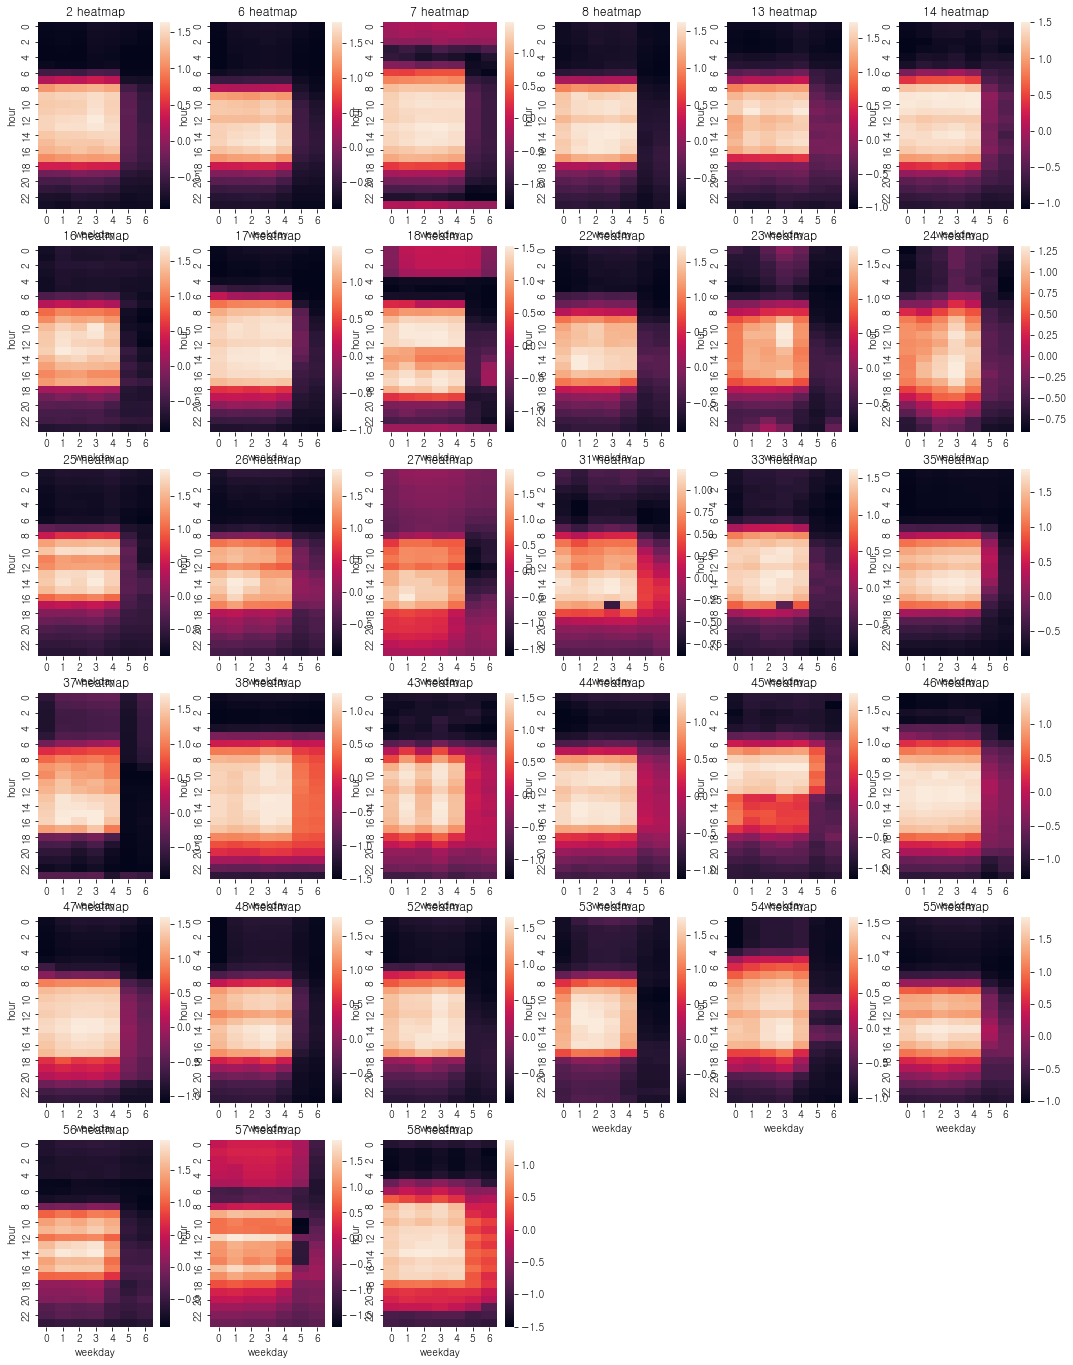

In [23]:
# km_1 번
fig = plt.figure(figsize=(18, np.ceil(len(km_1)/6)*4))
for i, n in enumerate(km_1):
    plt.subplot(int(np.ceil(len(km_1)/6)), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

평일 8~18시(업무시간) 전력사용량이 집중되어 있음
사무실, 상업시설이 공존하는 오피스형 건물로 추정

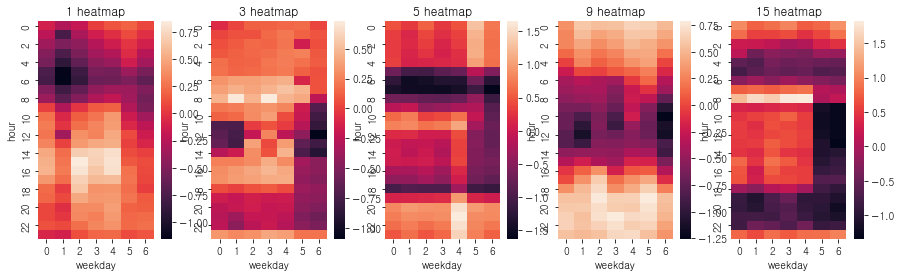

In [24]:
# km_2 번
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(int(np.ceil(len(km_2)/7)), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

24시간 운영, 24시간 돌아가는 공장이나 병원과 같은 곳이 아닐까

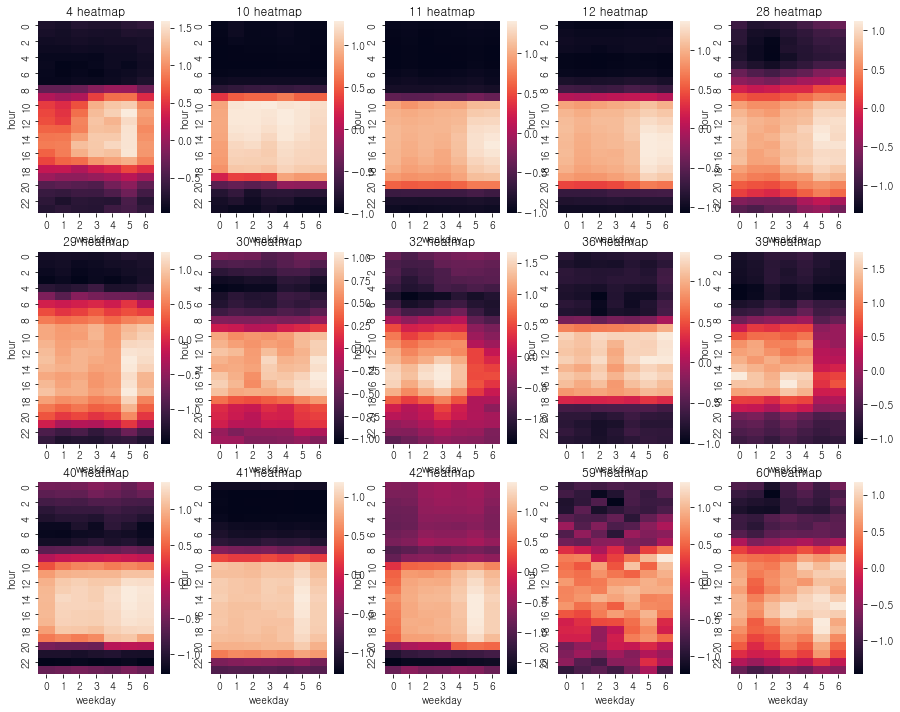

In [25]:
# km_3 번
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(int(np.ceil(len(km_3)/7)), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

일주일 운영, 9~20시 전력사용량 집중
일반적 상업시설이 존재하는 상가형 건물로 추정

### 2. 건물 별 시간에 대한 분석

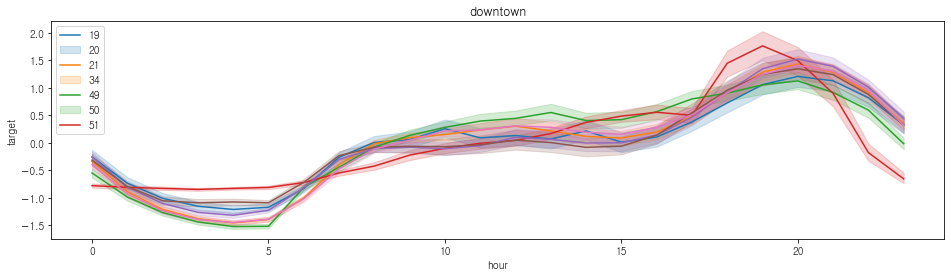

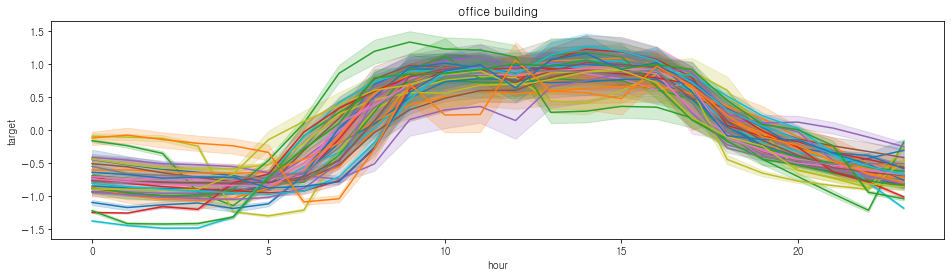

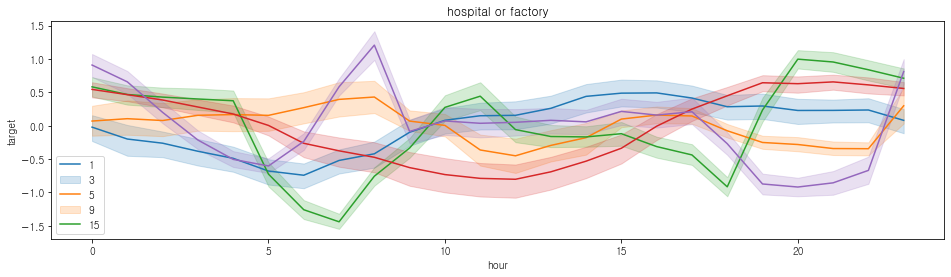

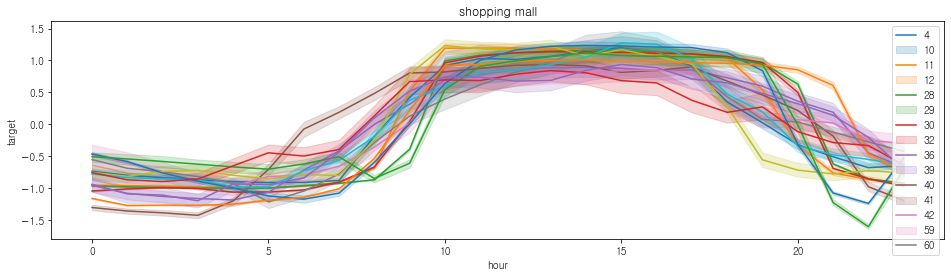

In [26]:
# 번화가형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 0].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 0) & (train_cl.num == i)], x='hour', y='target')
plt.title('downtown')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 0].num.unique()))

# 오피스형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 1].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 1) & (train_cl.num == i)], x='hour', y='target')
plt.title('office building')

# 병원, 공장형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 2].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 2) & (train_cl.num == i)], x='hour', y='target')
plt.title('hospital or factory')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 2].num.unique()))

# 상가형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 3].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 3) & (train_cl.num == i)], x='hour', y='target')
plt.title('shopping mall')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 3].num.unique()))

TODO 건물 유형별 날짜에 대한 분석

In [27]:
# # 번화가형
# (train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
# train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
# plt.legend(['temp', 'target'])
# plt.axvline(x = 183, color = 'r', linestyle = '--',)
# plt.axvline(x = 214, color = 'r', linestyle = '--',)
# plt.title('일별 기온 및 전력사용량 추이')
# plt.show()

In [28]:
# train_origin
# train_cl

**기상 변수에 대한 상관 분석**
1. 상관계수 구하기

In [29]:
# 피어슨 상관계수 사용
from scipy.stats import pearsonr

In [30]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [31]:
# 건물별로, 기상요인별로 전력소비량과의 상관계수를 계산해줍니다.
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [32]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)
corrs_cl_temp.head(10)

target  cooler  solar  temp_corr  humid_corr  sunny_corr  \
km_cluster num                                                             
0          19      0.0     0.0    0.0       0.60        0.03        0.17   
           20     -0.0     0.0    0.0       0.53       -0.12        0.12   
           21      0.0     0.0    1.0       0.62       -0.14        0.17   
           34     -0.0     1.0    1.0       0.46       -0.16        0.10   
           49      0.0     0.0    0.0       0.47       -0.05        0.04   
           50      0.0     0.0    0.0       0.54        0.05        0.13   
           51      0.0     0.0    1.0       0.50       -0.06        0.09   
1          2       0.0     1.0    0.0       0.45       -0.16        0.47   
           6       0.0     0.0    0.0       0.49       -0.41        0.42   
           7       0.0     1.0    0.0       0.24       -0.11        0.23   

                wind_corr  
km_cluster num             
0          19        0.23  
           20        0.19  
           21        0.23  
           34        0.22  
           49        0.17  
           50        0.19  
           51        0.21  
1          2         0.20  
           6         0.34  
           7         0.15

In [33]:
corrs_temp_temp = (corrs_cl_temp[['temp_corr', 'humid_corr', 'wind_corr']]
                   .reset_index()
                   .sort_values(by=['temp_corr', 'humid_corr', 'wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))
corrs_temp_temp.head(10)

,km_cluster,num,temp_corr,humid_corr,wind_corr
num,,,,,
31,1,31,0.78,-0.22,0.13
32,3,32,0.78,-0.63,0.34
30,3,30,0.77,-0.20,0.18
39,3,39,0.75,-0.55,0.33
60,3,60,0.69,-0.25,0.17
28,3,28,0.67,-0.02,0.30
44,1,44,0.67,-0.31,0.26
36,3,36,0.66,-0.43,0.35
24,1,24,0.65,-0.13,0.22


In [120]:
target_avg = train_origin.groupby('num')['target'].mean()
# train_avg['num']
# km_temp = []
# km_1_temp = []
# for num in km_1:
#     km_1_temp.append(train_origin[train_origin['num']==1]['target'].mean())
# km_temp.append(km_1_temp)
# km_temp

# train_avg[train_avg['num']==1]

# t = (corrs_cl_temp.temp_corr
#                    .reset_index()
#                    .sort_values(by=['temp_corr'], ascending=False)
#                   .set_index(['num'], drop=False))
                  
# corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

# corrs_temp_temp = (corrs_cl_temp.temp_corr
#                    .reset_index()
#                    .sort_values(by=['temp_corr'], ascending=False)
#                   .set_index(['num'], drop=False))

# corrs_temp_temp
# corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T

# plt.figure(figsize=(30, 2))
# plt.title('평균 사용량')
# sns.heatmap(km_temp, annot=True, linewidths=.5, vmin=0, vmax=8000)
# plt.show()

target_avg = train_origin.copy()
target_avg['km_cluster'] = None
target_avg

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,date,day,month,hour,weekday,weekend,dayofyear,km_cluster,num2
0,1,2020-06-01 00:00:00,8179.05600,17.60000,2.50000,92.00000,0.80000,0.00000,0.00000,0.00000,2020-06-01,1,6,0,0,0,153,None,1
1,1,2020-06-01 01:00:00,8135.64000,17.70000,2.90000,91.00000,0.30000,0.00000,0.00000,0.00000,2020-06-01,1,6,1,0,0,153,None,1
2,1,2020-06-01 02:00:00,8107.12800,17.50000,3.20000,91.00000,0.00000,0.00000,0.00000,0.00000,2020-06-01,1,6,2,0,0,153,None,1
3,1,2020-06-01 03:00:00,8048.80800,17.10000,3.20000,91.00000,0.00000,0.00000,0.00000,0.00000,2020-06-01,1,6,3,0,0,153,None,1
4,1,2020-06-01 04:00:00,8043.62400,17.00000,3.30000,92.00000,0.00000,0.00000,0.00000,0.00000,2020-06-01,1,6,4,0,0,153,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.36800,27.80000,2.30000,68.00000,0.00000,0.70000,1.00000,1.00000,2020-08-24,24,8,19,0,0,237,None,60
122396,60,2020-08-24 20:00:00,3975.69600,27.30000,1.20000,71.00000,0.00000,0.00000,1.00000,1.00000,2020-08-24,24,8,20,0,0,237,None,60
122397,60,2020-08-24 21:00:00,3572.20800,27.30000,1.80000,71.00000,0.00000,0.00000,1.00000,1.00000,2020-08-24,24,8,21,0,0,237,None,60
122398,60,2020-08-24 22:00:00,3299.18400,27.10000,1.80000,74.00000,0.00000,0.00000,1.00000,1.00000,2020-08-24,24,8,22,0,0,237,None,60


In [202]:
def heatmap_target_avg_of_num(km_num,train_origin):
    km_target = []
    for num in km_num:
        km_target.append(train_origin[train_origin['num']==num]['target'].mean())

    df = pd.DataFrame()
    df.index = km_num
    df['targert_avg'] = km_target

    plt.figure(figsize=(22, 1))
    plt.title('전력사용량')
    sns.heatmap(df.transpose(), annot=True, linewidths=.5, vmin=min(km_target), vmax=max(km_target))
    plt.show()

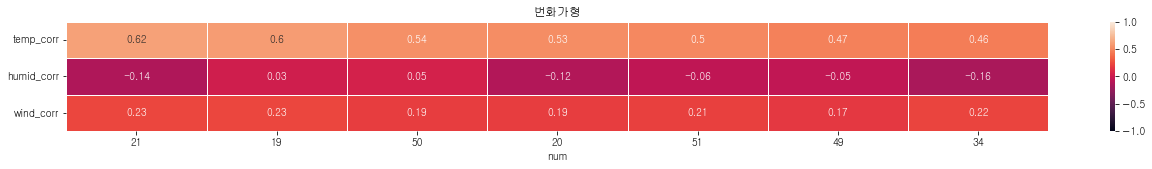

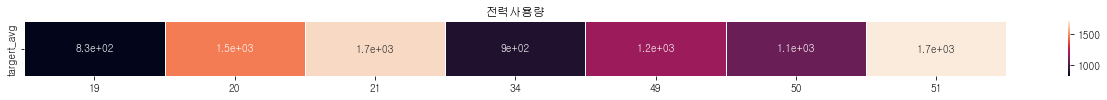

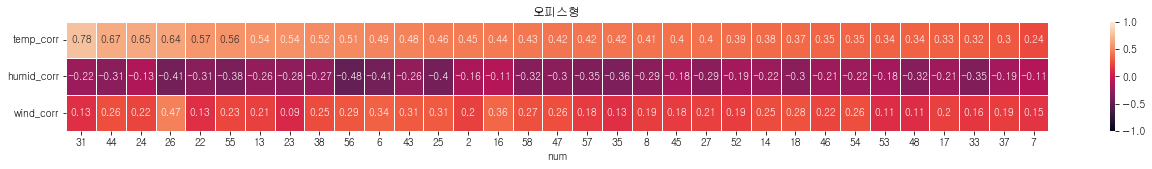

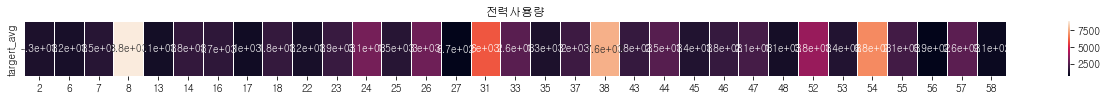

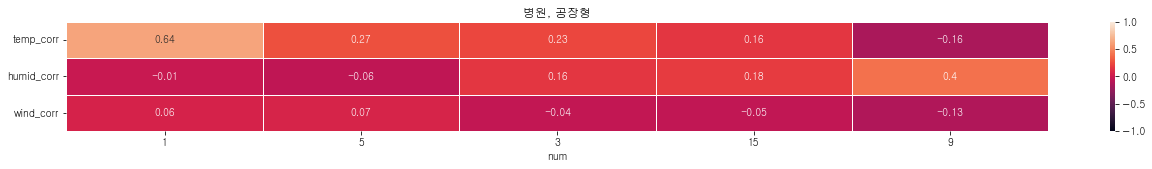

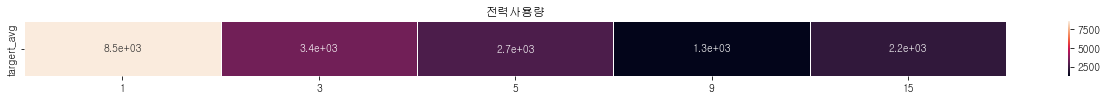

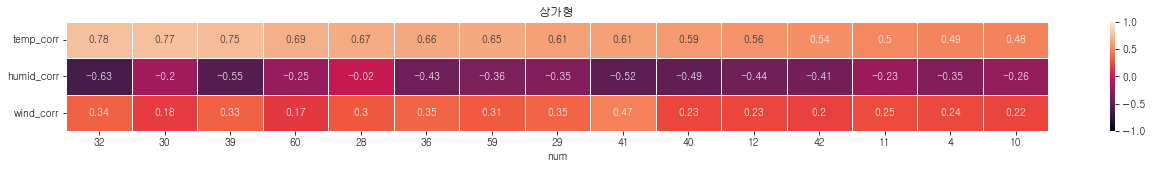

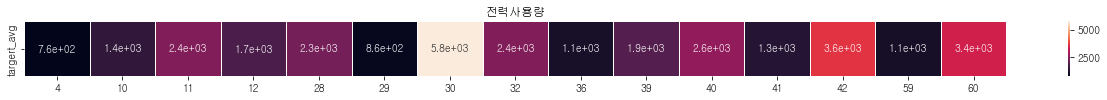

In [203]:
# 번화가형
plt.figure(figsize=(22, 2))
plt.title('번화가형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0][['temp_corr','humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_0,train_origin)

# 오피스형
plt.figure(figsize=(22, 2))
plt.title('오피스형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_1,train_origin)

# 병원, 공장형
plt.figure(figsize=(22, 2))
plt.title('병원, 공장형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_2,train_origin)

# 상가형
plt.figure(figsize=(22, 2))
plt.title('상가형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_3,train_origin)

기상의 영향을 많이 받는 건물이라면, 기온에 대한 양의 상관관계, 습도에 대한 음의 상관관계를 띄운다고 볼 수 있습니다.